<a href="https://colab.research.google.com/github/erikrosen01/LLM-saliency-map/blob/main/LLM_saliency_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

## Main class

In [75]:
class InteractiveSaliencyAnalyzer:
    def __init__(self):
        """Initialize GPT-2 model and tokenizer"""
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = GPT2LMHeadModel.from_pretrained('gpt2').to(self.device)
        self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

        # Set requires_grad to True for embedding layer
        for param in self.model.transformer.wte.parameters():
            param.requires_grad = True

    def generate_response(self, prompt, max_length=100):
        """Generate text response from prompt"""
        input_ids = self.tokenizer.encode(prompt, return_tensors='pt').to(self.device)

        # Generate response
        output_ids = self.model.generate(
            input_ids,
            max_length=max_length,
            num_return_sequences=1,
            pad_token_id=self.tokenizer.eos_token_id,
            do_sample=True,
            temperature=0.7
        )

        response = self.tokenizer.decode(output_ids[0], skip_special_tokens=True)
        return response[len(prompt):]  # Return only the generated part

    def compute_saliency(self, text, target_token):
        """Compute saliency scores for all tokens with respect to a target token."""
        self.model.zero_grad()

        input_ids = self.tokenizer.encode(text, return_tensors='pt').to(self.device)
        target_id = self.tokenizer.encode(target_token)[0]
        target_positions = (input_ids == target_id).nonzero()

        if len(target_positions) == 0:
            raise ValueError(f"Target token '{target_token}' not found in input text")

        target_position = target_positions[0][1]

        embeddings = self.model.transformer.wte(input_ids)
        embeddings.retain_grad()

        hidden_states = self.model.transformer(inputs_embeds=embeddings).last_hidden_state
        hidden_state = hidden_states[0, target_position]

        hidden_state.norm().backward()

        if embeddings.grad is None:
            raise ValueError("No gradients were computed. Check if target token exists in the sequence.")

        embedding_gradients = embeddings.grad[0].norm(dim=-1)
        saliency_scores = embedding_gradients.cpu().detach().numpy()

        tokens = [self.tokenizer.decode(token_id.item()) for token_id in input_ids[0]]
        return tokens, saliency_scores

    def visualize_saliency(self, text, target_token, figsize=(12, 4), cmap='YlOrRd',
                          show_scores=True, title=None):
        """
        Create a matplotlib visualization of token saliencies.

        Args:
            text (str): Input text to analyze
            target_token (str): Token to compute saliency with respect to
            figsize (tuple): Figure size (width, height)
            cmap (str): Colormap for visualization
            show_scores (bool): Whether to show numerical scores
            title (str): Custom title for the plot
        """
        tokens, scores = self.compute_saliency(text, target_token)

        # Remove all values after the analyzed token since their all zero
        token_index = np.argmax(scores)
        scores = scores[:token_index+1]
        tokens = tokens[:token_index+1]

        # Set score of the analyzed token to value in the range of other values
        # If not it will be the largest in normalization making the visualization hard to see
        scores[-1] = np.mean(scores)

        # Normalize scores
        normalized_scores = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)

        normalized_scores[-1] = 1

        # Create figure and axis
        fig, ax = plt.subplots(figsize=figsize)

        # Plot heatmap background
        max_token_len = max(len(token) for token in tokens)
        token_boxes = []

        for i, (token, score) in enumerate(zip(tokens, normalized_scores)):
            # Create background rectangle for each token
            rect = Rectangle((i, 0), 1, 1, facecolor=plt.cm.get_cmap(cmap)(score))
            ax.add_patch(rect)
            token_boxes.append((i + 0.5, 0.5))

        # Add tokens as text
        for (x, y), token, score in zip(token_boxes, tokens, normalized_scores):
            text_color = 'white' if score > 0.5 else 'black'
            if show_scores:
                display_text = f"{token}\n{score:.2f}"
            else:
                display_text = token
            ax.text(x, y, display_text, ha='center', va='center', color=text_color)

        # Set plot limits and aspect
        ax.set_xlim(0, len(tokens))
        ax.set_ylim(0, 1)
        ax.set_aspect('equal')

        # Remove axes
        ax.set_xticks([])
        ax.set_yticks([])

        # Set title
        if title is None:
            title = f'Token Saliency Analysis (target: "{target_token}")'
        plt.title(title)

        # Add colorbar
        sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap(cmap))
        sm.set_array([])
        plt.colorbar(sm, ax=ax, orientation='vertical', label='Saliency Score')

        plt.tight_layout()
        return fig, ax

    def interactive_session(self):
        """Run an interactive session in Jupyter notebook"""
        from IPython.display import clear_output

        while True:
            # Get prompt from user
            prompt = input("Enter your prompt (or press enter to exit): ")
            if prompt.lower() == '':
                break

            # Generate response
            response = self.generate_response(prompt)
            print("\nGenerated response:")
            print(response)

            text = prompt + response

            # Get token for analysis
            target = input("\nEnter token to analyze (or press Enter to skip): ")
            if target:
                try:
                    # Create visualization
                    self.visualize_saliency(text, target)
                    plt.show()
                except ValueError as e:
                    print(f"Error: {e}")

            print("\n" + "="*50 + "\n")


analyzer = InteractiveSaliencyAnalyzer()

## Usecase 1a
Get the model to generate text to then be analyzed using the saliency map

In [73]:
# Generate text

query = "Once upon a time"
text = analyzer.generate_response(query)

text = query + text

print(text)

Once upon a time, I would have been able to make something of it. I have done this to myself, and many of you have done it to me."

"It's not what I want to do," the younger girl said. "It's what I want to do. I can't wait to see what it's like to have this kind of power."

"I'm not that powerful. I'm not that powerful," the older man said. "I'm not


<ipython-input-64-7609dc5b6f4d>:97: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rect = Rectangle((i, 0), 1, 1, facecolor=plt.cm.get_cmap(cmap)(score))
<ipython-input-64-7609dc5b6f4d>:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap(cmap))


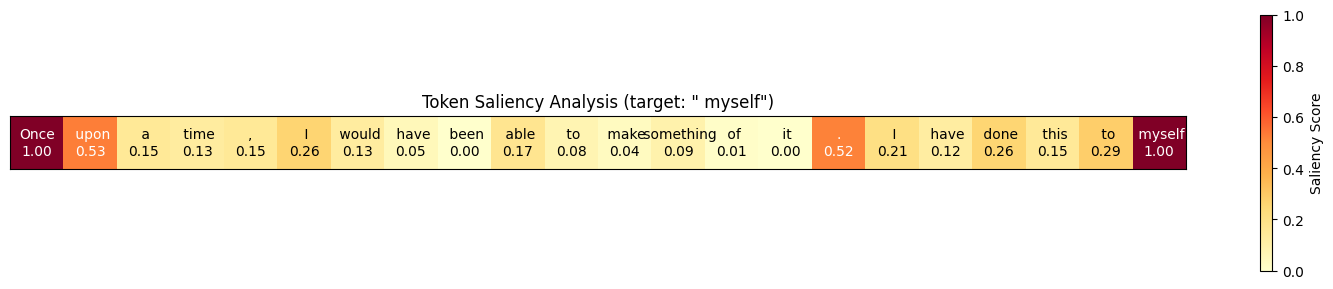

In [74]:
# Create visualization

analyzer.visualize_saliency(text, " myself", figsize=(15, 3))
plt.show()

## Usecase 1b
Enter a prompt and get the model to respond using a small interactive window.
Then use the saliency map to analyze the response.

Enter your prompt (or press enter to exit): China is the

Generated response:
 world's largest energy exporter, with nearly 6.8 billion barrels of oil and gas produced. But in recent years, the country has been struggling to keep pace with the growth of China's economy, which has been expanding at a remarkable pace over the past two decades.

"China is a major energy producer and has been able to maintain its competitive position in the world," said Joseph Kump, senior economist at Goldman Sachs in New York, who added that China's share

Enter token to analyze (or press Enter to skip):  gas


<ipython-input-75-69873c16062e>:97: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rect = Rectangle((i, 0), 1, 1, facecolor=plt.cm.get_cmap(cmap)(score))
<ipython-input-75-69873c16062e>:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap(cmap))


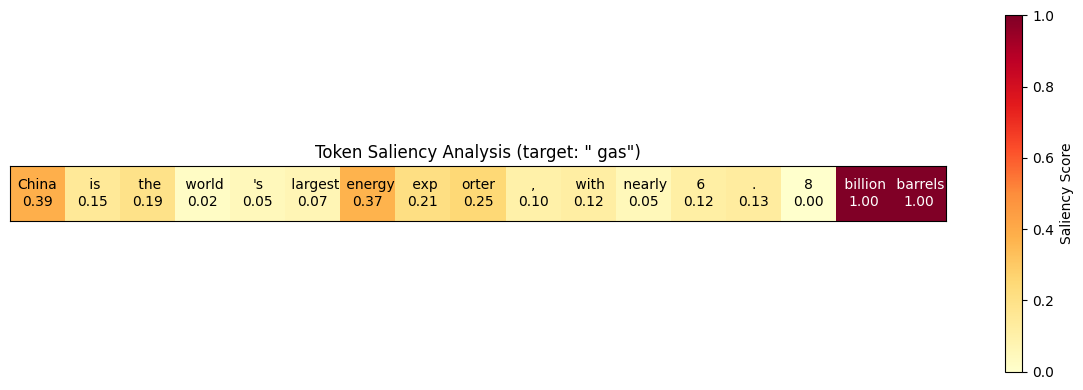



Enter your prompt (or press enter to exit): 


In [77]:
analyzer = InteractiveSaliencyAnalyzer()
analyzer.interactive_session()

## Usecase 3
Enter your own text and get the model to analyze using a saliency map

<ipython-input-64-7609dc5b6f4d>:97: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rect = Rectangle((i, 0), 1, 1, facecolor=plt.cm.get_cmap(cmap)(score))
<ipython-input-64-7609dc5b6f4d>:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap(cmap))


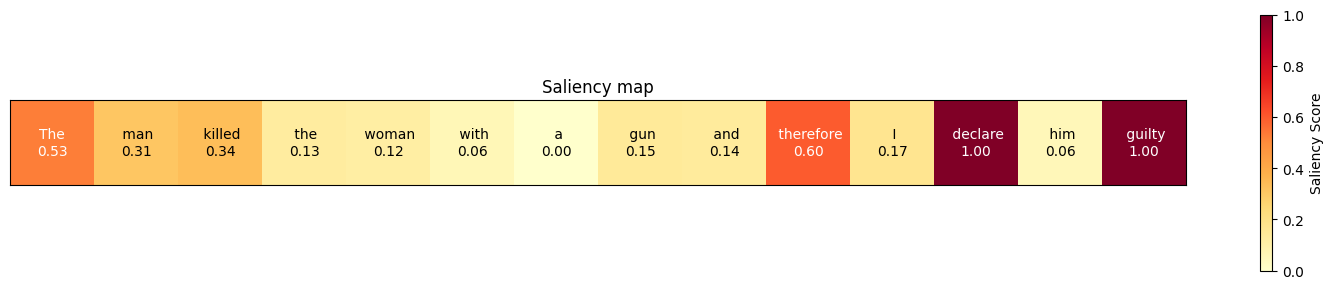

In [72]:
analyzer = InteractiveSaliencyAnalyzer()
text = "The man killed the woman with a gun and therefore I declare him guilty"

# Create visualization with custom settings
fig, ax = analyzer.visualize_saliency(
    text,
    " guilty",
    figsize=(15, 3),
    show_scores=True,
    title='Saliency map'
)
plt.show()